In [1]:
import warnings
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import pymc3 as pm
import theano.tensor as tt
import arviz as az
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

az.style.use('arviz-whitegrid')
warnings.filterwarnings('ignore', module='seaborn')

In [2]:
# Set the random seed
np.random.seed(42)

# Linear Regression

## Linear Regression

Probabilistically, a **linear regression** model can be expressed as follows:

$$\mu = \alpha + X\beta$$
$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

where $X$ denotes the input feature, $Y$ denotes the target feature, and $\alpha$ and $\beta$ are respectively *intercept* and *slope* of the linear relationship.
So, the targets are assumed to be distributed as a Gaussian with mean $\alpha + \beta X$ and standard deviation $\epsilon$, which controls the amount of noise in our data.# Linear Regression

Since we do not know the values of $\alpha$, $\beta$ or $\epsilon$, we have to set prior distributions for them.
A common yet reasonable choice for such distributions are the Gaussian and the non-negative Gaussian distribution (also called Half-Gaussian).

Alternatively, a prior distribution on the amount of noise can be the non-negative Cauchy distribution (also called Half-Cauchy), which have longer tails hence permitting to explore a wider space when sampling from the posterior.

$$\alpha \sim \mathrm{Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathrm{Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathrm{Normal}(0,\sigma_\epsilon)| \quad\text{or}\quad \epsilon \sim |\mathrm{Cauchy}(0,\sigma_\epsilon)|$$

The usage of Gaussian priors for the weights $\alpha$ and $\beta$ means that we are _penalizing_ very large absolute values in favour of values near zero.

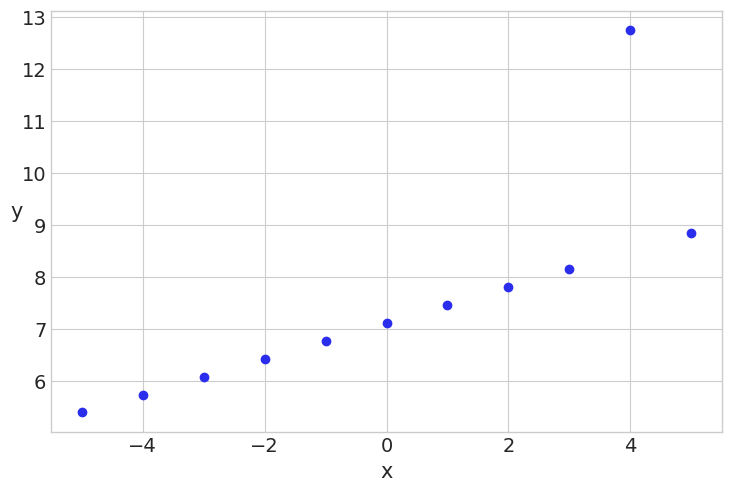

In [3]:
# Load one of the Anscombe quartet
data = pd.read_csv('data/anscombe.csv')
x = data[data.group == 'III']['x'].values
y = data[data.group == 'III']['y'].values
x -= x.mean()

# Plot the data
plt.plot(x, y, 'o')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

Using PyMC3 we can build a linear regression model with almost a _one-to-one_ correspondence with the formulas showed above.
Moreover, we can easily sample from the **posterior distribution**.
In other words, we obtain the parameters values that are _consistent_ with the underlying data, of course with different amount of _likelihood_.

In [4]:
# Build a PyMC3 linear regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0.0, sd=8.0)
    beta = pm.Normal('beta', mu=0.0, sd=8.0)
    eps = pm.HalfCauchy('eps', 5.0)
    y_pred = pm.Normal('y_pred', mu=alpha + x * beta, sd=eps, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 14 seconds.


Using Arviz we can plot both the posterior distributions of our parameters, the obtained traces given by the **Markov Chain Monte Carlo** (MCMC) procedure, and the related auto-correlogram.

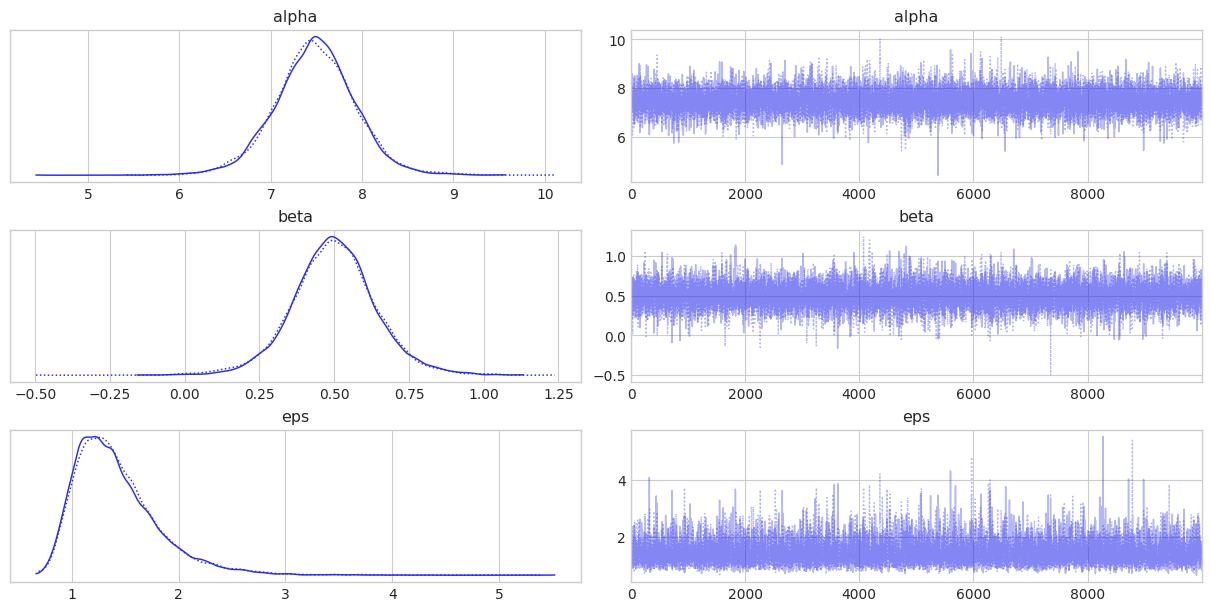

In [5]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps'])
plt.show()

[]

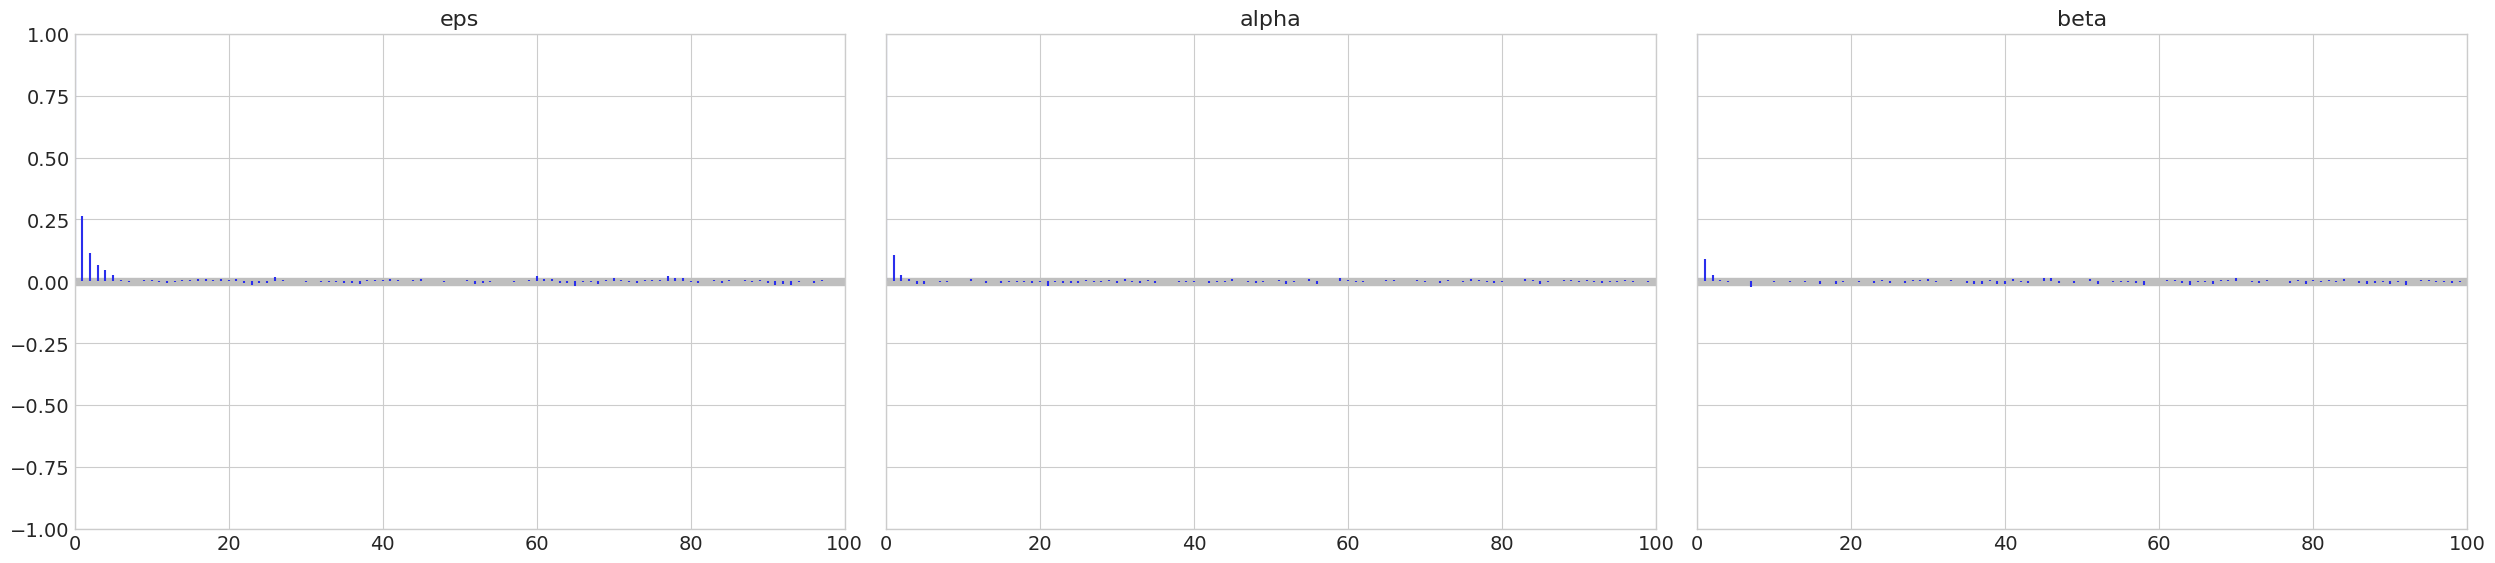

In [6]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['eps', 'alpha', 'beta'], combined=True)
plt.plot()

For graphical representation purposes, we can consider the _average_ of the sampled values for $\alpha$ and $\beta$ parameters.
Moreover, for each input data point we can sample from the _conditional_ probability distribution using PyMC3.
So, in other words we can plot the target samples in the **Highest Density Interval** (HDI). 

In [7]:
# Compute average values of sampled parameters
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

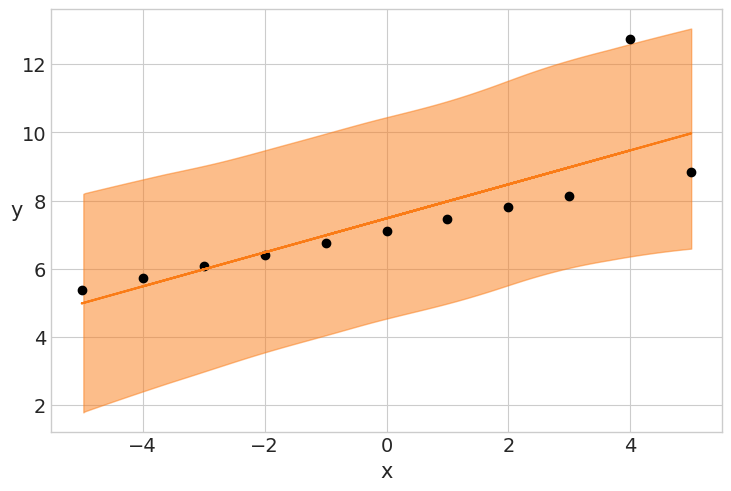

In [8]:
# Plot the HDI graph
az.plot_hdi(x, ppc['y_pred'])
plt.plot(x, y, 'o', c='k')
plt.plot(x, alpha_m + beta_m * x, c='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

## Robust Linear Regression

As noted previously, the presence of outliers in our data might make our Gaussian assumption fail.
In general a Student t-distribution is a way to effectively deal with outliers and get a more robust inference.
To do so, we must define another prior distribution over the _degrees of freedom_ of the Student t-distribution.
A common choice for this prior is given by a translated Exponential distribution.
The resulting robust linear regression model is defined below.

$$\alpha \sim \mathrm{Normal}(\mu_\alpha, \sigma_\alpha)$$
$$\beta \sim \mathrm{Normal}(\mu_\beta, \sigma_\beta)$$
$$\epsilon \sim |\mathrm{Normal}(0,\sigma_\epsilon)|$$
$$\nu \sim 1 + \mathrm{Exponential}(\lambda)$$
$$y \sim \alpha + \beta X + \epsilon \cdot \mathcal{StudentT}(\nu)$$

In [9]:
# Build a PyMC3 linear (robust) regression model
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0.0, sd=8.0)
    beta = pm.Normal('beta', mu=0.0, sd=8.0)
    eps = pm.HalfCauchy('eps', 5.0)
    nu = 1 + pm.Exponential('nu', 1.0 / 29.0)
    y_pred = pm.StudentT('y_pred', mu=alpha + x * beta, sd=eps, nu=nu, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000, target_accept=0.9,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, eps, beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 27 seconds.
The number of effective samples is smaller than 25% for some parameters.


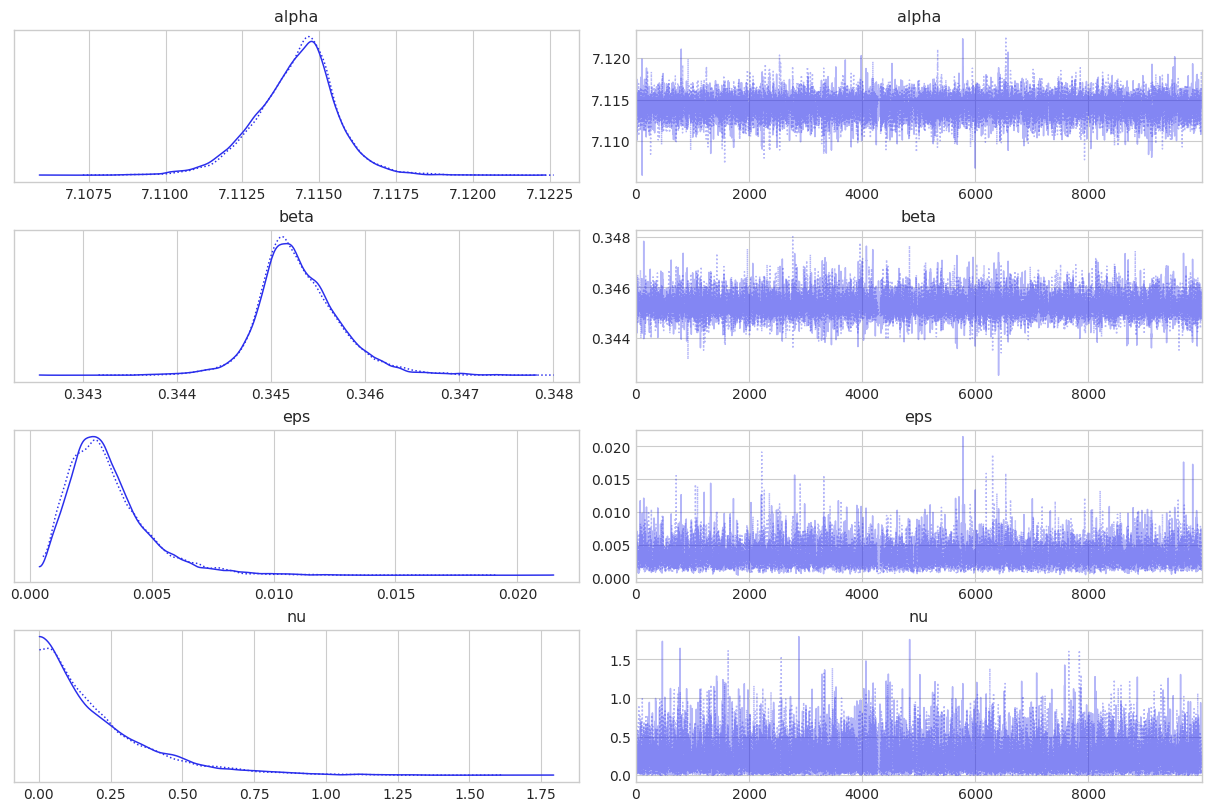

In [10]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps', 'nu'])
plt.show()

As we can see, the relevance of important outliers is strictly reduced.
In this case the posterior predictive distribution collapses to a single point.

In [11]:
# Compute average values of sampled parameters
alpha_m = trace['posterior']['alpha'].mean().item()
beta_m = trace['posterior']['beta'].mean().item()

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

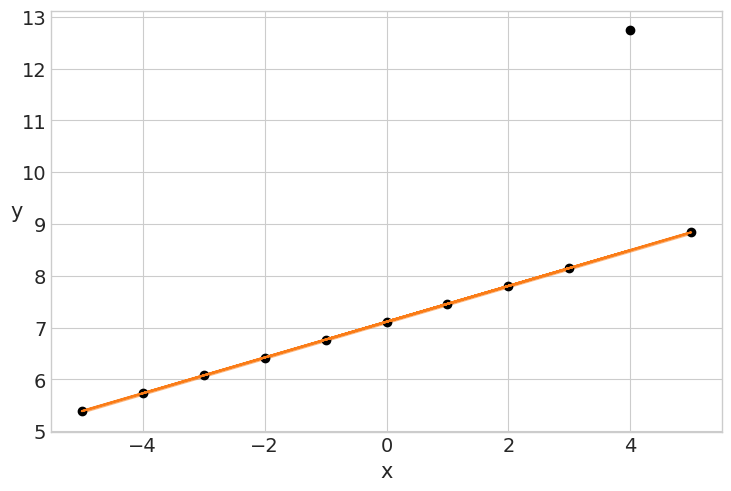

In [12]:
# Plot the HDI graph
az.plot_hdi(x, ppc['y_pred'])
plt.plot(x, y, 'o', c='k')
plt.plot(x, alpha_m + beta_m * x, c='C1')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.show()

# Generalized Linear Mdels

## Generalized Linear Models

A generalized linear model (GLM) is a flexible generalization of ordinary linear regression.
It generalizes linear regression by allowing the linear model to be related to the response variable via an **inverse link function** $f$.

$$\mu = f(\alpha + X\beta)$$

There are many inverse link function that can be used,
the simplest one is the _identity function_.
Others inverse link functions can be used to deal with _categorical variables_ or to _restrict the output_ to an interval (e.g. only positive).

## Logistic Regression

The **logistic regression** model is a generalization of the linear regression model, and thus its name.
We achieve this generalization by placing the _logistic function_ as an inverse link function.

$$\sigma(z) = \frac{1}{1+\exp(-z)}$$

where $\sigma: \mathbb{R} \to (0,1)$ denotes the logistic function.

The **logistic regression** model can be then formalized as follows.

$$\theta = \sigma(\alpha + X\beta)$$

$$Y \sim \mathrm{Bernoulli}(\theta)$$

[]

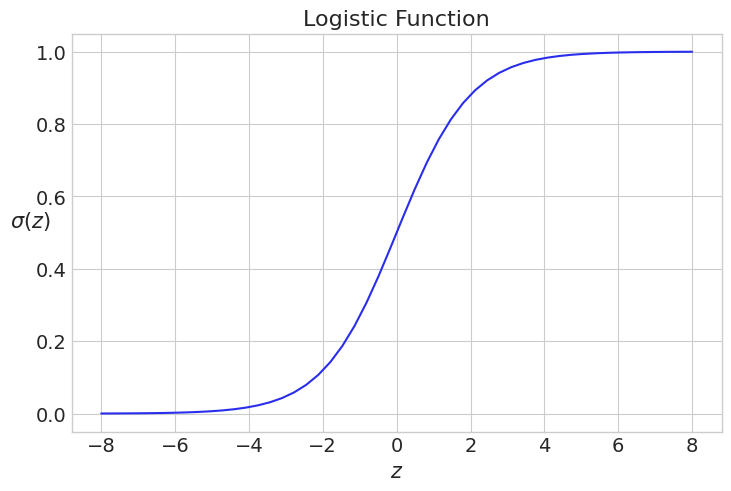

In [13]:
z = np.linspace(-8, 8)
plt.plot(z, 1 / (1 + np.exp(-z)))
plt.xlabel('$z$')
plt.ylabel('$\sigma(z)$', rotation=0)
plt.title('Logistic Function'); plt.plot()

### Example

We will take in account a simple classification task with the IRIS dataset:
- 50 individual samples for each species
- 4 variable for each sample
- 3 classes

In [14]:
# Load the IRIS dataset
iris = pd.read_csv('data/iris.csv')
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


[]

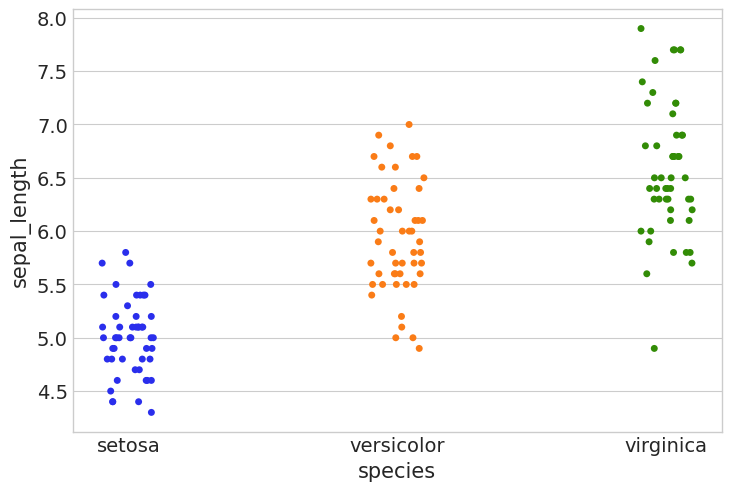

In [15]:
# The jitter has no meaning, is only for better visualization
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True); plt.plot()

[]

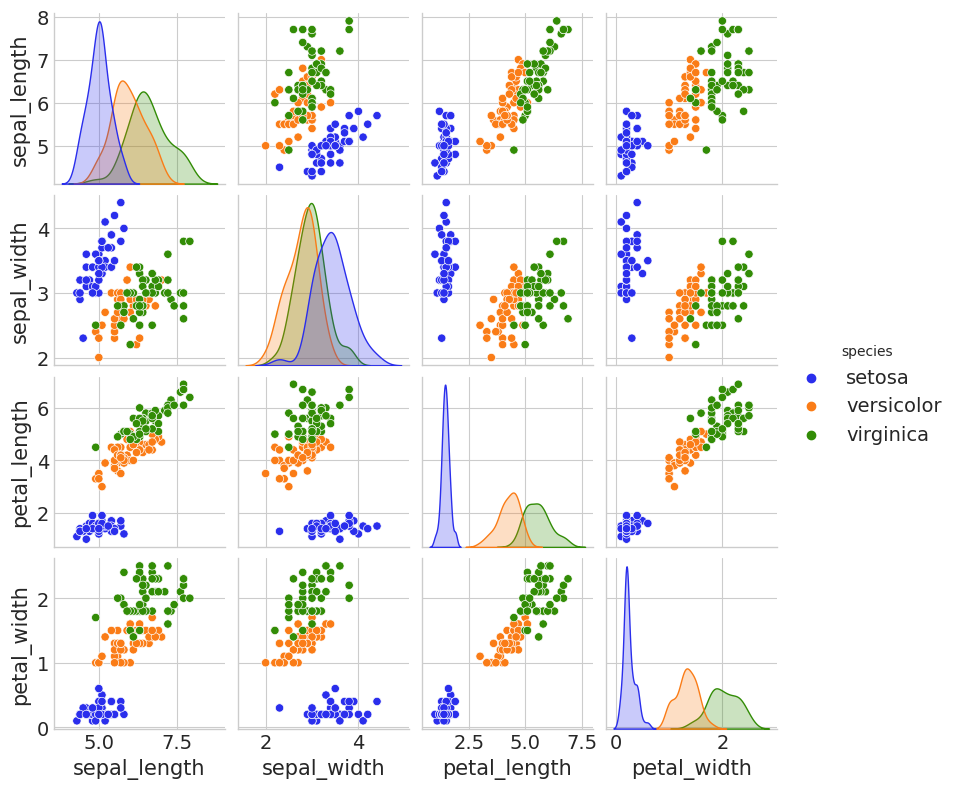

In [16]:
# Plot the pair-plot
sns.pairplot(iris, hue='species', diag_kind='kde', height=2); plt.plot()

We are now interested in a binary classification task:
- Two classes: `setosa` and `versicolor`;
- Just one independent variable (or feature): `sepal_lenght`

In [17]:
# Setup the binary IRIS dataset
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x = df[x_n].values
x_c = x - x.mean()

Centering the data can help in the process of sampling from the posterior.

In [18]:
# Build a PyMC3 logistic regression model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0, sd=10.0)
    beta = pm.Normal('beta', mu=0, sd=5.0)
    
    # Likelihood
    mu = alpha + beta * x_c
    theta = pm.Deterministic('theta', tt.nnet.sigmoid(mu))  # Output of the logistic regression
    bd = pm.Deterministic('bd', -alpha / beta)  # Boundary decision (unused deterministic variable)
    yl = pm.Bernoulli('yl', p=theta, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=10_000, tune=10_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 10_000 tune and 10_000 draw iterations (20_000 + 20_000 draws total) took 11 seconds.


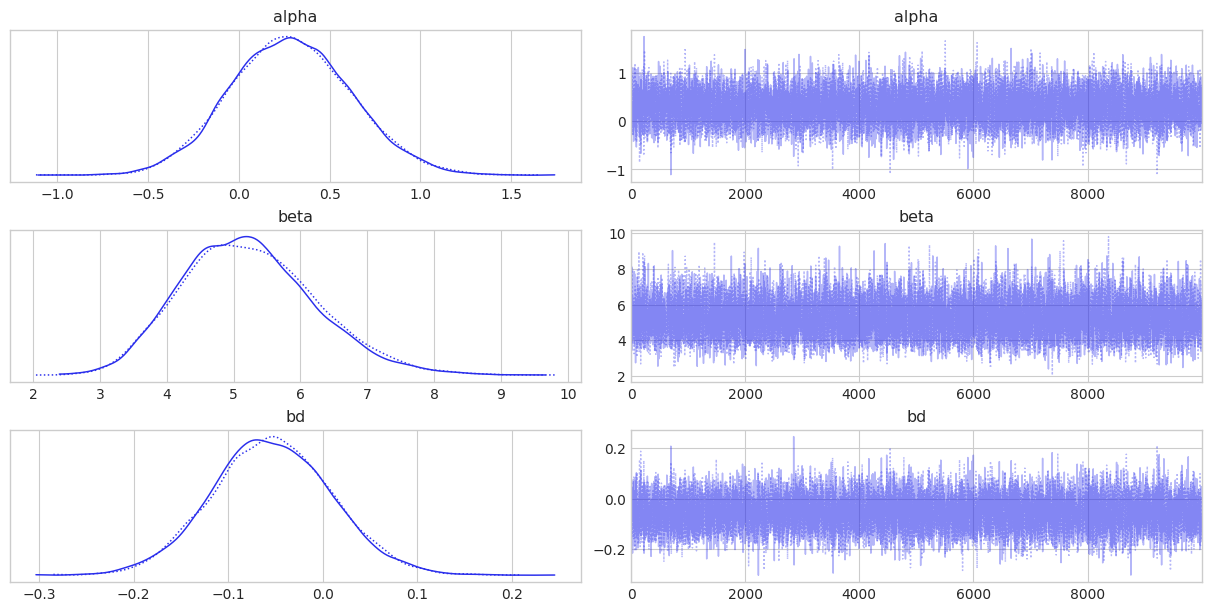

In [19]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'bd'])
plt.show()

[]

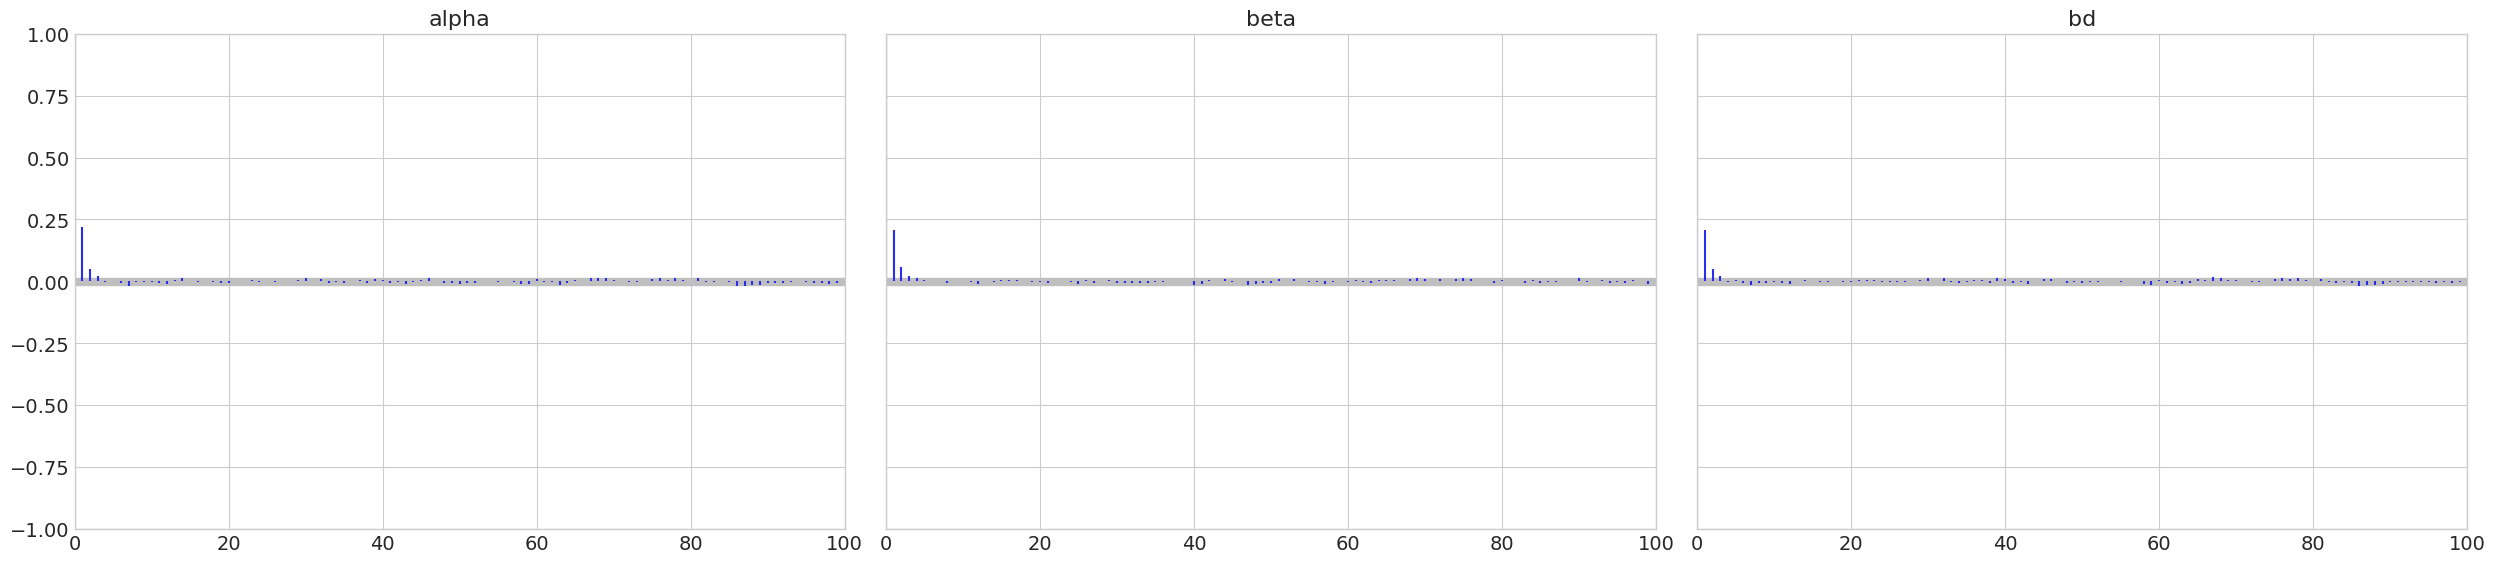

In [20]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'bd'], combined=True)
plt.plot()

In [21]:
def plot_logistic_decision_boundary(trace):
    posterior = trace['posterior']
    theta = posterior['theta']
    bd = posterior['bd']
    
    plt.scatter(x_c, np.random.normal(y, 0.02), marker='.', color=[f'C{c}' for c in y])
    az.plot_hdi(x_c, theta, color='C2')
    idx = np.argsort(x_c)
    avg_theta = np.mean(np.asarray(theta).reshape(-1, len(x_c)), axis=0)
    plt.plot(x_c[idx], avg_theta[idx], color='C2', lw=2)
    
    bd_hdi = az.hdi(bd)
    plt.fill_betweenx([0, 1], bd_hdi['bd'][0], bd_hdi['bd'][1], color='k', alpha=0.5)
    plt.vlines(bd.mean(), 0, 1, color='k')

    # Use original scale for xticks
    locs, _ = plt.xticks(); plt.xticks(locs, np.round(locs + x.mean(), 1))
    
    plt.xlabel(x_n)
    plt.ylabel('$\\theta$', rotation=0)
    plt.show()

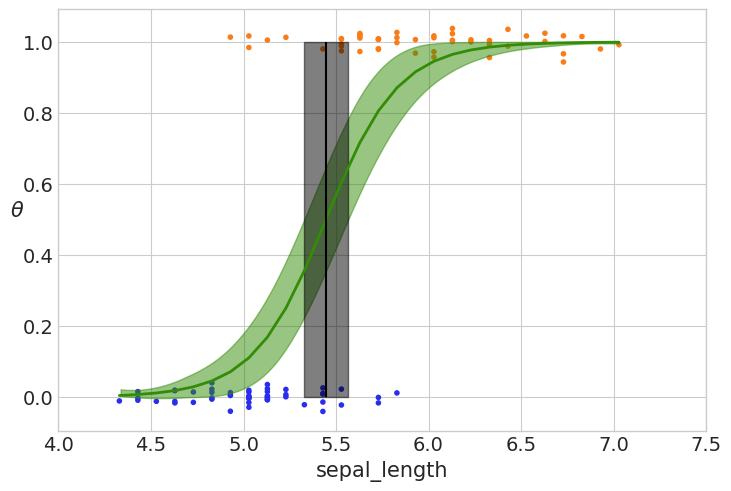

In [22]:
# Plot the decision boundary
plot_logistic_decision_boundary(trace)

The green line can be interpreted as the probability distribution of a flower being `versicolor` based on its `sepal_length`.

The boundary decision is represented as a (black) vertical line with a semi-transparent band for its 94% High Density Interval (HDI).

Note that the centroid of the boundary decision is the $X$ point where $Y=0.5$.

## Multivariate Linear and Logistic Regression

We can extend the **linear regression** model for multivariate data with $d$ features as follows.

$$\mu = \alpha + X^T\beta = \alpha + \sum_{i=1}^d \beta_iX_i$$

$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

where $X$ denotes the input features and Y denotes the target feature.
Note that we have different _slope_ parameters for each dimension.

Generally, linear regression enable a straightforward interpretation of parameters.
Each _slope_ parameter $\beta_i$ can be interpreted as the quantity to addition (or subtract) to the target variable $Y$, with a unit change of the $i$-th feature $X_i$.

Similarly, we can also extend the **logistic regression** model for multivariate data with $d$ features as follows.

$$\theta = \sigma(\alpha + X^T\beta)$$

$$Y \sim \mathrm{Bernoulli}(\theta)$$

### Example

In [23]:
# Setup the multivariate IRIS dataset for logistic regression
df = iris.query("species == ('setosa', 'versicolor')")
y = pd.Categorical(df['species']).codes
x_n = ['sepal_length', 'sepal_width']
x = df[x_n].values
x_c = x - x.mean(axis=0)

In [24]:
# Build a PyMC3 multivariate logistic regression model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0, sd=10.0)
    beta = pm.Normal('beta', mu=0, sd=5.0, shape=len(x_n))

    # Likelihood
    mu = alpha + tt.dot(x_c, beta)
    theta = pm.Deterministic('θ', tt.nnet.sigmoid(mu))
    bd = pm.Deterministic('bd', -alpha / beta[1] - beta[0] / beta[1] * x_c[:, 0])
    yl = pm.Bernoulli('yl', p=theta, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=20_000, tune=30_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 30_000 tune and 20_000 draw iterations (60_000 + 40_000 draws total) took 37 seconds.


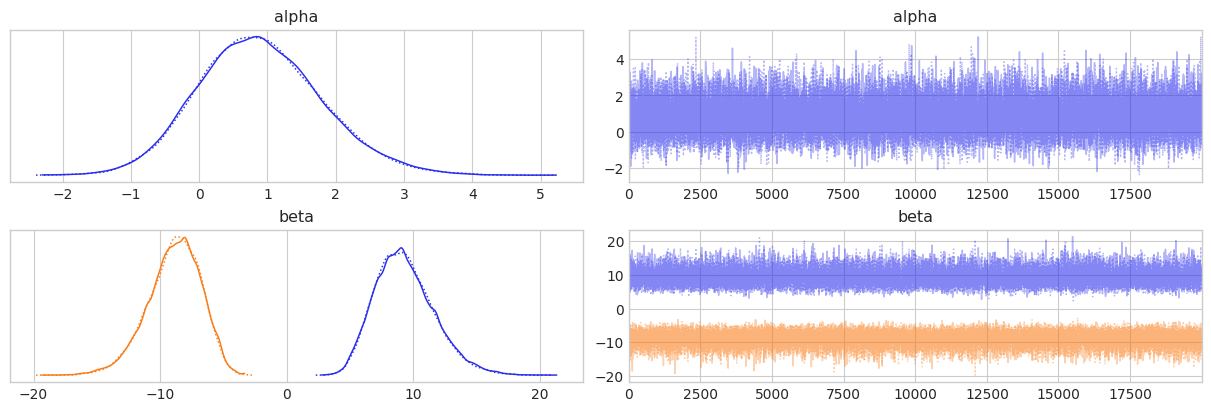

In [25]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta'])
plt.show()

[]

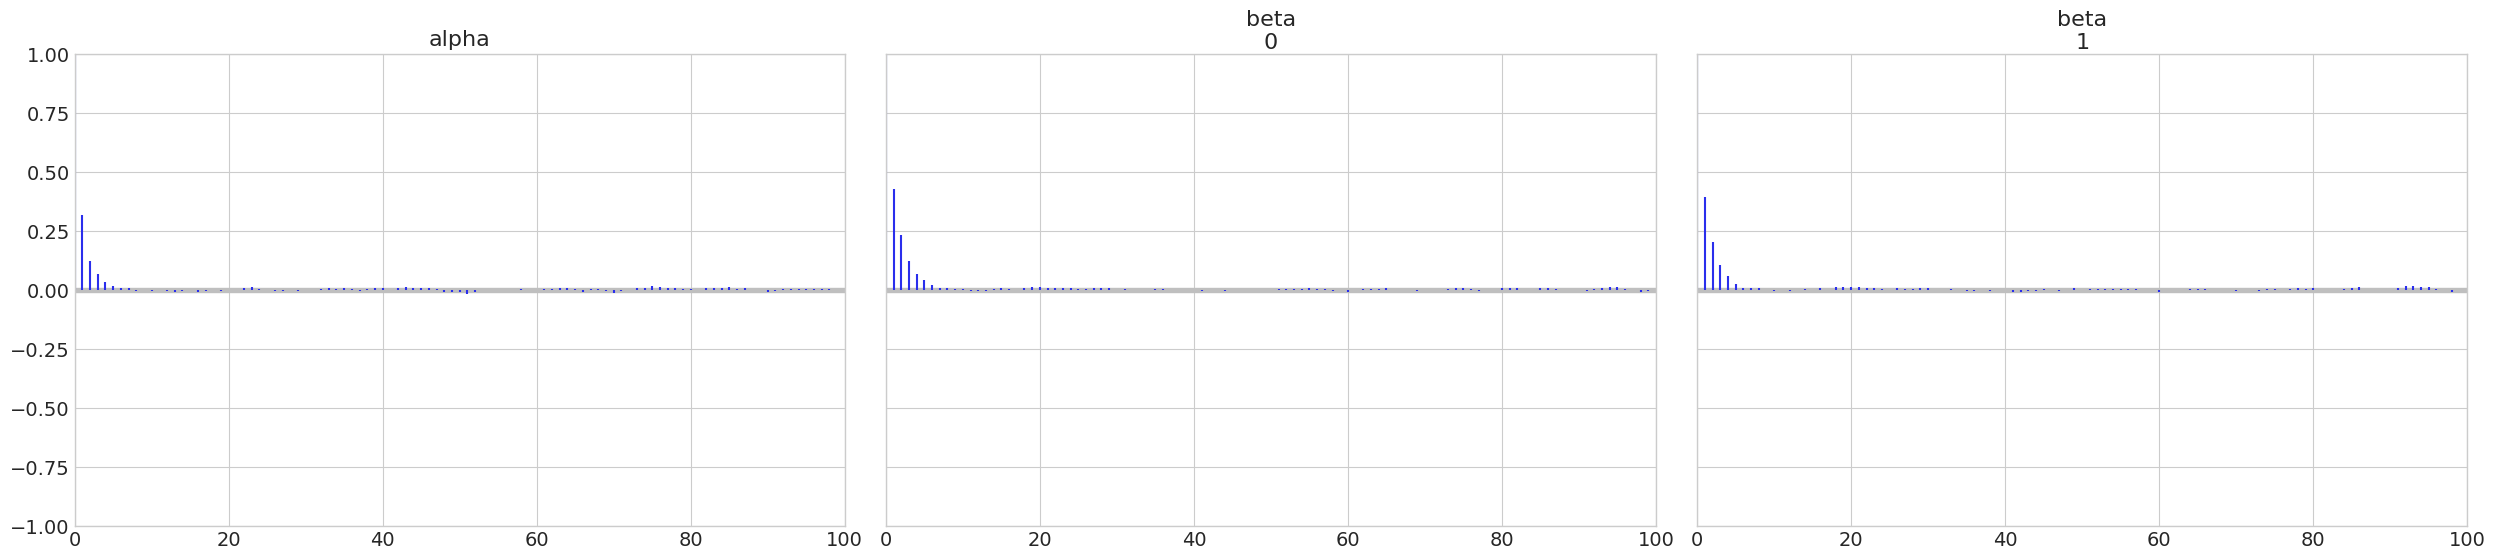

In [26]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta'], combined=True)
plt.plot()

In [27]:
def plot_logistic_decision_boundary_2d(trace):
    posterior = trace['posterior']
    bd = posterior['bd']

    idx = np.argsort(x_c[:, 0])
    avg_bd = np.mean(np.asarray(bd).reshape(-1, len(x_c)), axis=0)
    plt.scatter(x_c[:, 0], x_c[: ,1], c=[f'C{c}' for c in y])
    
    az.plot_hdi(x_c[:, 0], bd, color='k')
    plt.plot(x_c[:, 0][idx], avg_bd[idx], color='k')

    # Use original scale for xticks and yticks
    locs, _ = plt.xticks(); plt.xticks(locs, np.round(locs + x.mean(axis=0)[0], 1))
    locs, _ = plt.yticks(); plt.yticks(locs, np.round(locs + x.mean(axis=0)[1], 1))
    
    plt.xlabel(x_n[0])
    plt.ylabel(x_n[1])
    plt.show()

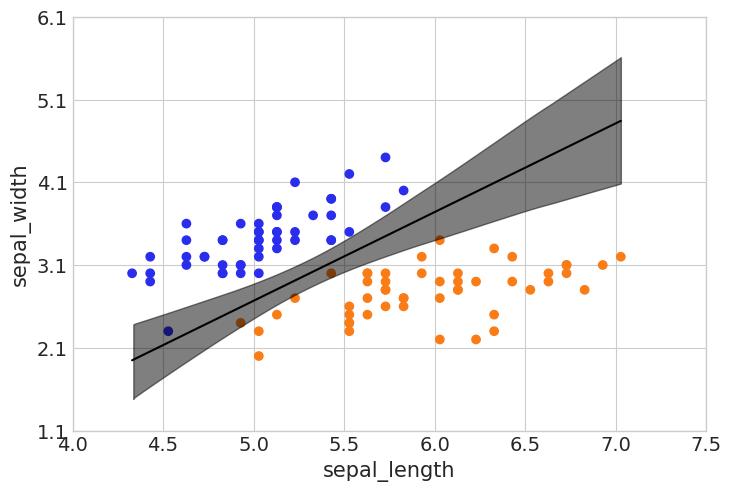

In [28]:
# Plot the decision boundary
plot_logistic_decision_boundary_2d(trace)

# Poisson Regression

## Poisson Regression

Another very popular generalized linear model is the **Poisson regression**. This model assumes data is distributed according to the Poisson distribution.

One scenario where Poisson distribution is useful is when _counting_ things, such as:
- the decay of a radioactive nucleus;
- the number of children per couple, or the number of Twitter followers;
- models using discrete non-negative integers

The probability mass function (PMF) of the Poisson distribution is defined as follows.

$$f(k;\ \theta) = \frac{\theta^k e^{-\theta}}{k!}$$

where $\theta$ is the average number of eventt per unit of time (or space), and $k$ is a non-negative integer. Note that both expectation and variance of a Poisson distribution coincide with $\theta$.

## Zero-Inflated Poisson model

Often when performing posterior predictive check, model generates fewer 0s compared to the data.
Howe do we model such case ?

We assume we have a mixture of two processes modeled by:
- Poisson distribution with probability $\psi$;
- _extra zeros_ with probability $1 - \psi$.

The **Zero-Inflated Poisson (ZIP)** model can formalized as follows.

$$P(Y = 0) = 1 - \psi + \psi e^{-\theta}$$
$$P(Y = x_i) = \psi\frac{\mu^{x_i} e^{-\theta}}{x_i!}$$

We use the exponential function as inverse-link function to ensure positive numbers, i.e. $\theta = e^{\alpha + X\beta}$.

### Example

The fish dataset has the following characteristics:
- 250 group of visitors at park
    - number of fish they caught (`count`);
    - children per group (`child`);
    - brought a camper or not (`camper`).

We are going to build a model that predicts the number of fish caught.

In [29]:
fish_data = pd.read_csv('data/fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [30]:
# Build a PyMC3 ZIP regression model
with pm.Model() as model:
    # Prior distributions
    psi = pm.Beta('psi', 1.0, 1.0)
    alpha = pm.Normal('alpha', mu=0.0, sd=10.0)
    beta = pm.Normal('beta', 0.0, 10.0, shape=2)

    # Likelihood
    theta = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    yl = pm.ZeroInflatedPoisson('yl', psi, theta, observed=fish_data['count'])

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=20_000, tune=30_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]


Sampling 2 chains for 30_000 tune and 20_000 draw iterations (60_000 + 40_000 draws total) took 83 seconds.


In [31]:
def plot_fish_distributions(trace):
    posterior = trace['posterior']
    alpha = np.asarray(posterior['alpha']).reshape(-1)
    beta = np.asarray(posterior['beta']).reshape(-1, 2)
    idx = np.random.choice(len(alpha), 1024, replace=False)
    alpha = alpha[idx]
    beta = beta[idx]
    children = [0, 1, 2, 3, 4]
    fish_count_pred_0 = []
    fish_count_pred_1 = []
    for n in children:
        without_camper = alpha + beta[:, 0] * n
        with_camper = without_camper + beta[:, 1]
        fish_count_pred_0.append(np.exp(without_camper))
        fish_count_pred_1.append(np.exp(with_camper))
    plt.plot(children, fish_count_pred_0, 'C0.', alpha=0.01)
    plt.plot(children, fish_count_pred_1, 'C1.', alpha=0.01)

    plt.xticks(children);
    plt.xlabel('Number of Children')
    plt.ylabel('Fish Caught')
    plt.plot([], 'C0o', label='Without Camper')
    plt.plot([], 'C1o', label='With Camper')
    plt.legend()
    plt.show()  

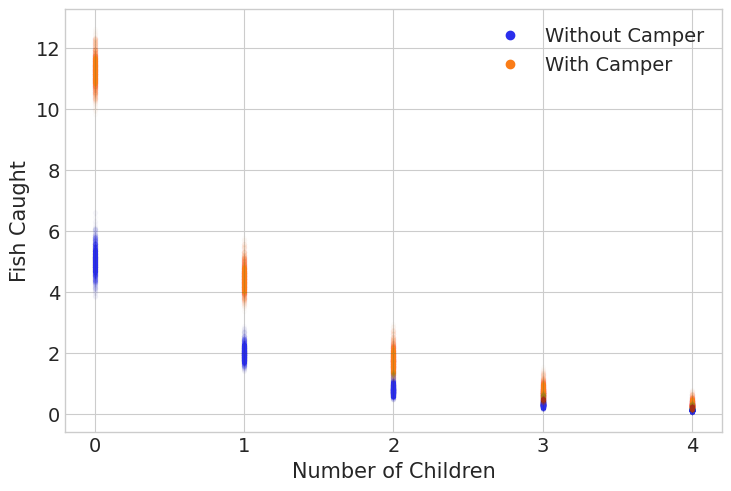

In [32]:
# Plot the distributions of fish caught with and without camper
# and with varying the number of children
plot_fish_distributions(trace)

We can highlight the following points.
- Expected number of fish caught decreases as number of children increases;
- Having a camper increases the expected count of fish.

# Polynomial Regression

## Univariate Polynomial Regression

Similarly to linear regression we introduce the **polynomial regression** model as following.

$$\mu = \alpha + \sum_{i=1}^N \beta_iX^i = \alpha + \beta_1X + \beta_2X^2 + \ldots + \beta_NX^N$$
$$Y \sim \mathrm{Normal}(\mu,\epsilon)$$

where $N$ is the _degree_ of the polynomial.
Just like classical linear regression, we can impose prior distributions on the parameters of our model.

Polynomial regression is useful in cases we need to model _non-linear characteristics_ of a target variable with respect to the other features.
However, one problem of polynomial regression is that interpreting the weights $\beta_i$ is difficult.
That is, fixing a feature $X$ we have several weights (each for the $i$-th power) that influence the value of the target variable, and they can also be positive or negative independently.

In [33]:
def plot_overfitting_polynomial(n1, n2):
    # Initialize a random state
    random_state = np.random.RandomState(42)
    
    # Load one of the Anscombe quartet
    data = pd.read_csv('data/anscombe.csv')
    x = data[data.group == 'II']['x'].to_numpy()[:, np.newaxis]
    y = data[data.group == 'II']['y'].to_numpy()
    x += 0.5 * random_state.randn(*x.shape)
    y += 0.5 * random_state.randn(*y.shape)
    
    # Fit polynomials
    poly1 = PolynomialFeatures(degree=n1)
    poly2 = PolynomialFeatures(degree=n2)
    model1 = LinearRegression().fit(poly1.fit_transform(x), y)
    model2 = LinearRegression().fit(poly2.fit_transform(x), y)
    x_pred = np.linspace(x.min() - 0.1, x.max() + 0.1, 300)[:, np.newaxis]
    y_pred1 = model1.predict(poly1.transform(x_pred));
    y_pred2 = model2.predict(poly2.transform(x_pred))

    # Plot the data and the fitting polynomial
    plt.figure(figsize=(6, 4))
    plt.scatter(x.squeeze(), y, s=16, c='k', label='Data Points')
    plt.plot(x_pred, y_pred1, label='Poly. N={}'.format(poly1.degree))
    plt.plot(x_pred, y_pred2, label='Poly. N={}'.format(poly2.degree))
    plt.xlabel('x')
    plt.ylabel('y', rotation=0)
    plt.legend()
    plt.show()

Another problem is that it is always possible to find a polynomial that _perfectly fits_ the data.
However, fitting _perfectly_ the data is not a good idea since the resultinig model will not be a good representation of _un-observed_ data.
This is known as **overfitting**.

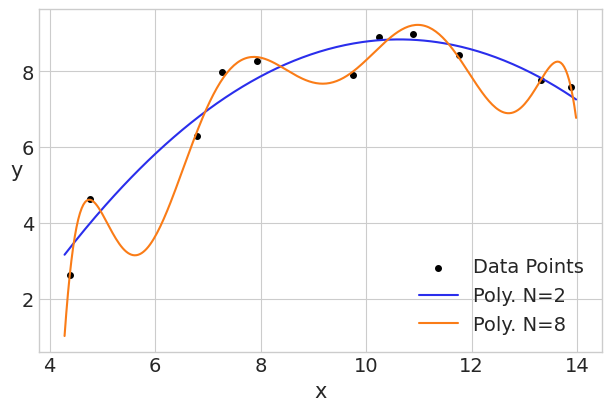

In [34]:
# Plot two polynomials, one of them overfits the data
plot_overfitting_polynomial(n1=2, n2=8)

Polynomial regression can be performed easily using linear regression on the _augmented_ data built based on the polynomial grade. 
In regression analysis, we can refer to the _augmented_ data matrix with possibly additional interactions between features as the **design matrix**.

In other words, we _expand the feature space_ and then fit a linear regression model in the expanded space.
We can generalize this concept by introducing **basis functions** $B_i:\mathbb{R}\to\mathbb{R}$.

$$\mu = \alpha + \sum_{i=1}^M \beta_iB_i(X) = \alpha + \beta_1B_1(X) + \beta_2B_2(X) + \ldots + \beta_MB_M(X)$$

$$Y \sim \mathrm{Normal}(\mu,\epsilon)$$

When $B_i$ is the $i$-th power function, we recover the univariate polynomial regression model.
This can be generalized as well also for multivariate data.

### Example

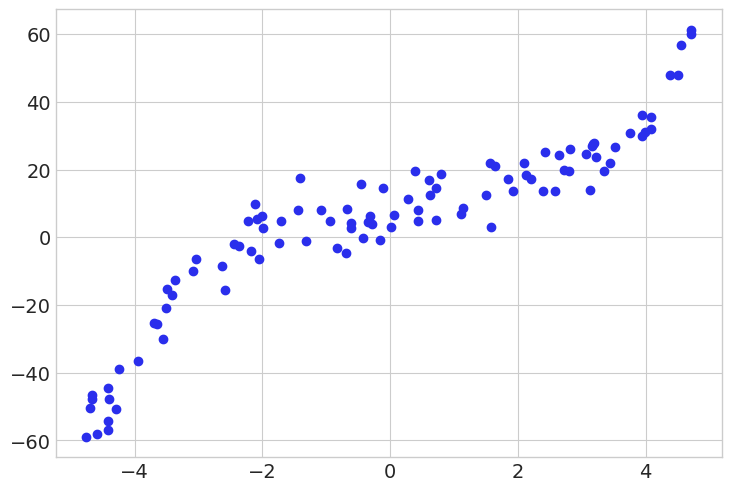

In [35]:
# Setup a noisy non-linear function
def nl(x): return 0.5 * (x ** 3) - 0.5 * (x ** 2) + 1.0 * x + 10.0
x = 5.0 * (2.0 * np.random.rand(100) - 1.0)
y = nl(x) + 5.0 * np.random.randn(len(x))
plt.plot(x, y, 'o')
plt.show()

In [36]:
# Apply the polynomial basis function
basis_x = np.stack([x, x ** 2.0, x ** 3], axis=1)

# Build a PyMC3 multivariate linear regression model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0.0, sd=10.0)
    beta = pm.Normal('beta', mu=0.0, sd=3.0, shape=basis_x.shape[1])
    eps = pm.HalfCauchy('eps', 5.0)

    # Likelihood
    mu = pm.Deterministic('mu', alpha + tt.dot(basis_x, beta))
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=40_000, tune=40_000,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 40_000 tune and 40_000 draw iterations (80_000 + 80_000 draws total) took 104 seconds.


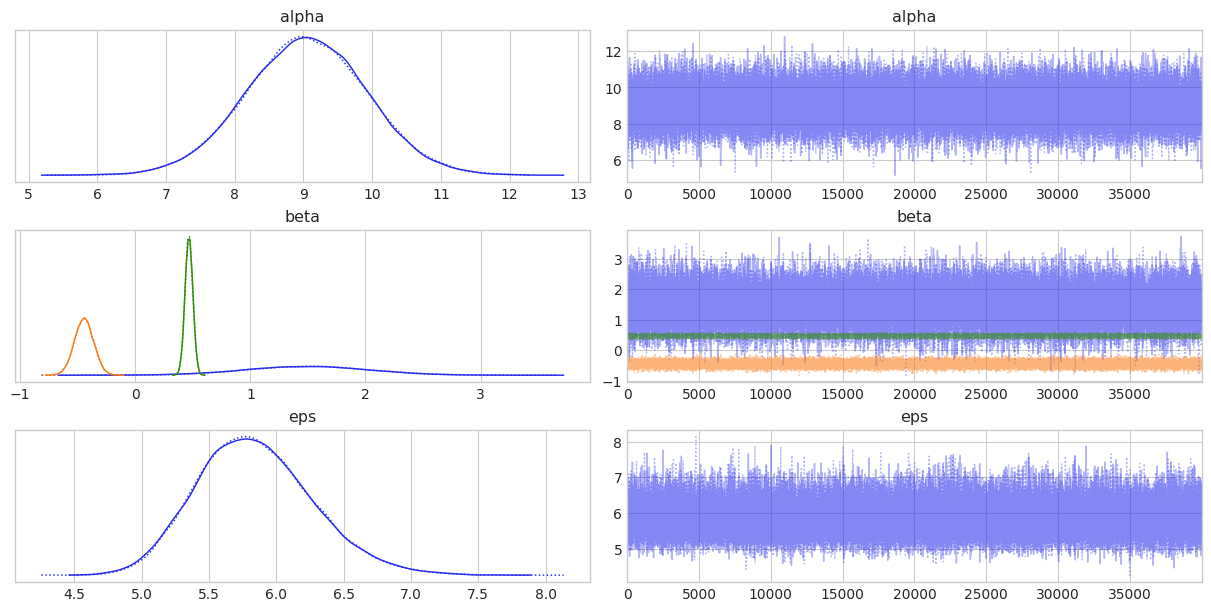

In [37]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps'])
plt.show()

[]

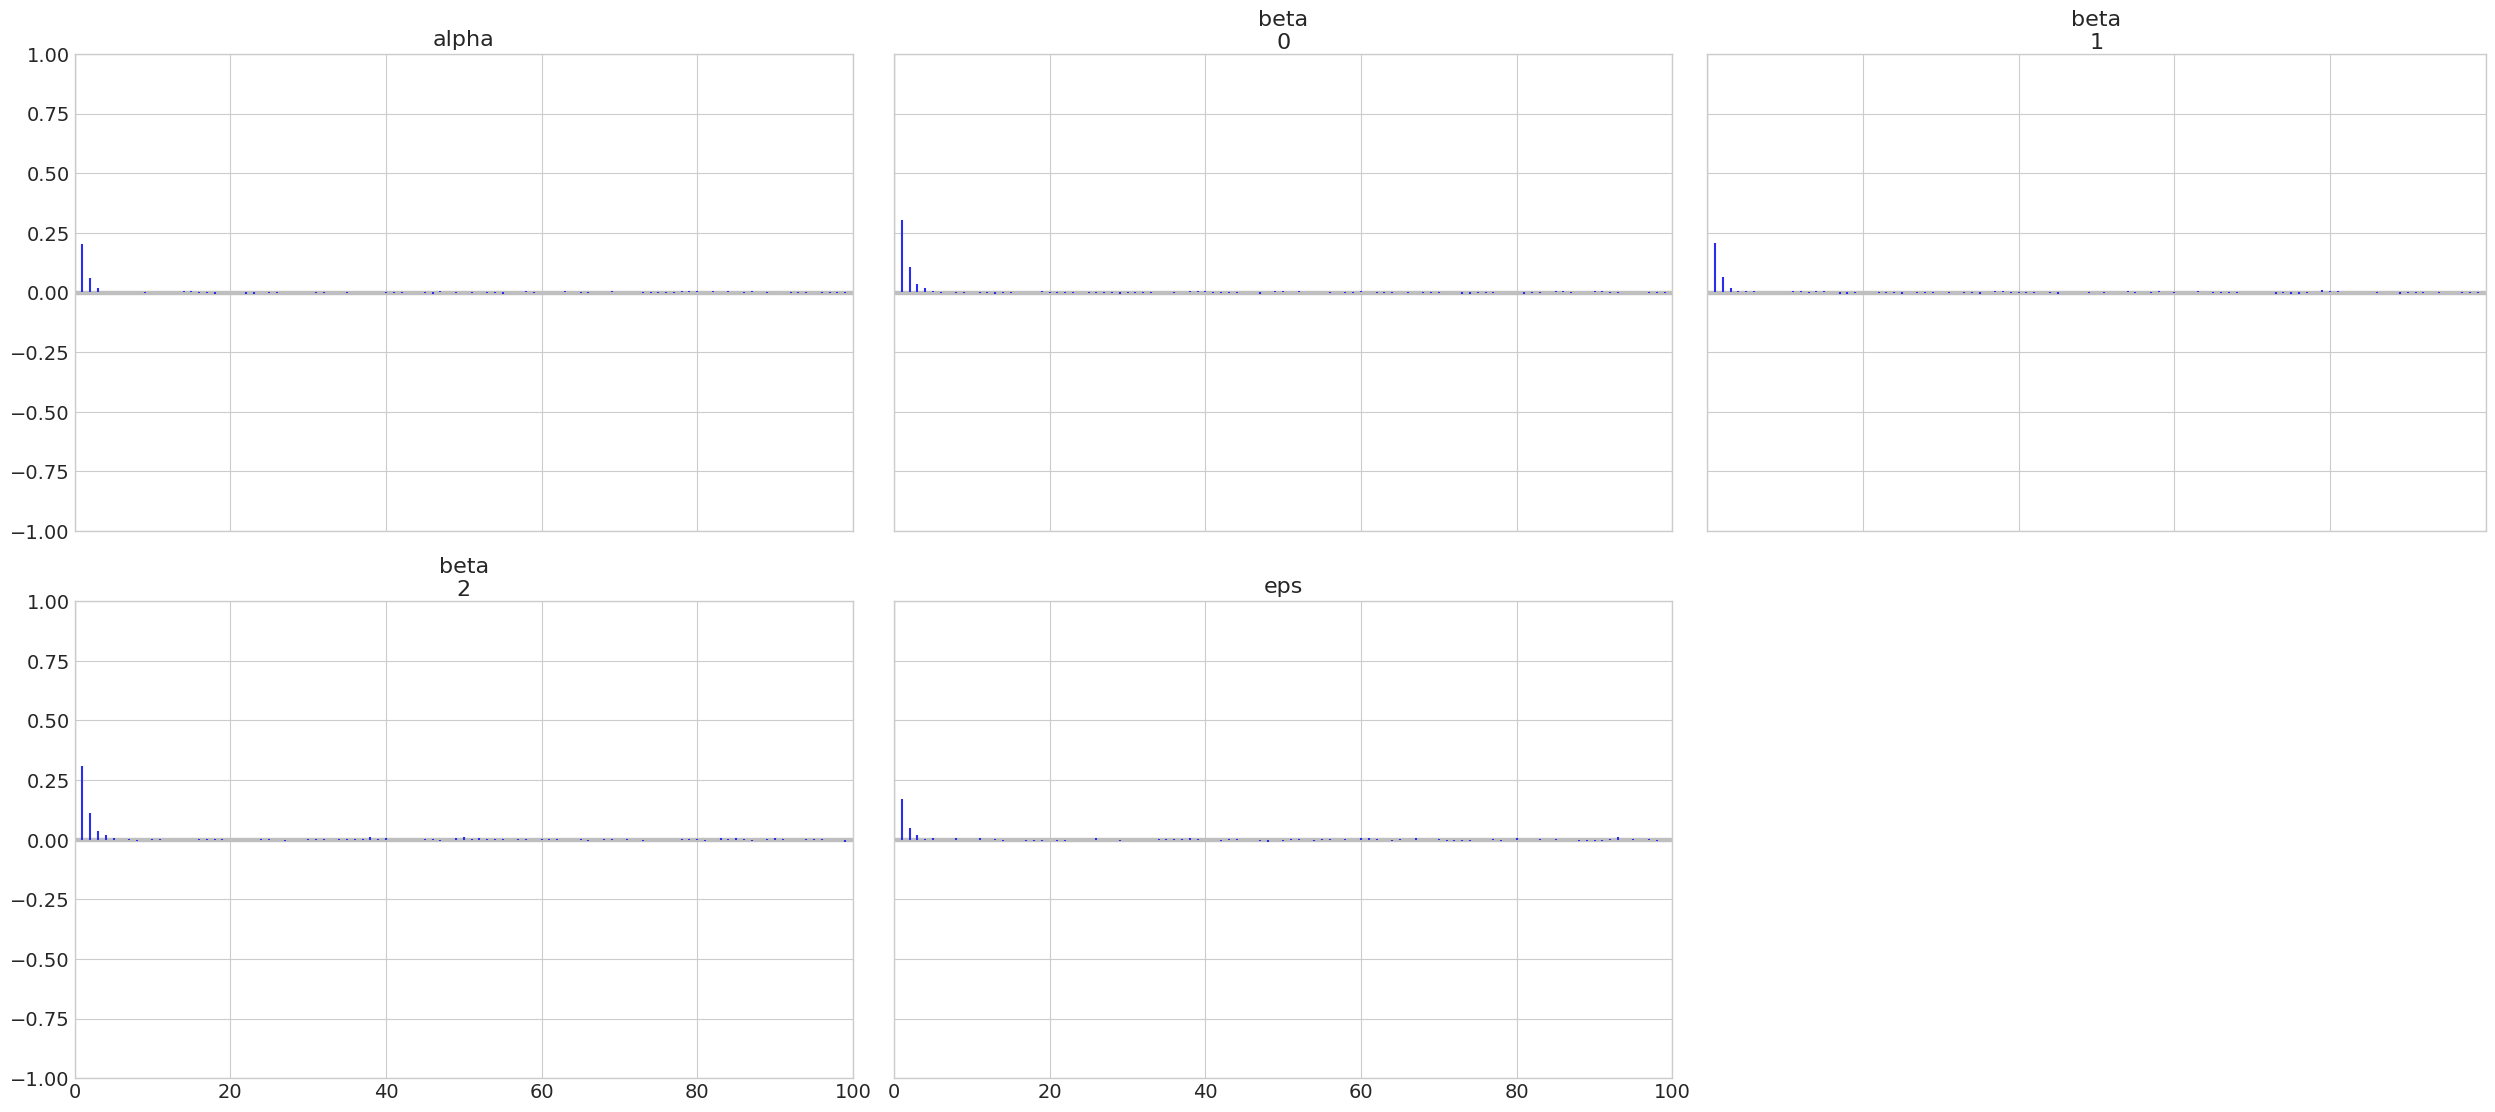

In [38]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'eps'], combined=True)
plt.plot()

In [39]:
# Compute average values of sampled parameters
alpha_m = np.asarray(trace['posterior']['alpha']).mean()
beta_m = np.asarray(trace['posterior']['beta']).reshape(-1, basis_x.shape[1]).mean(axis=0)

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

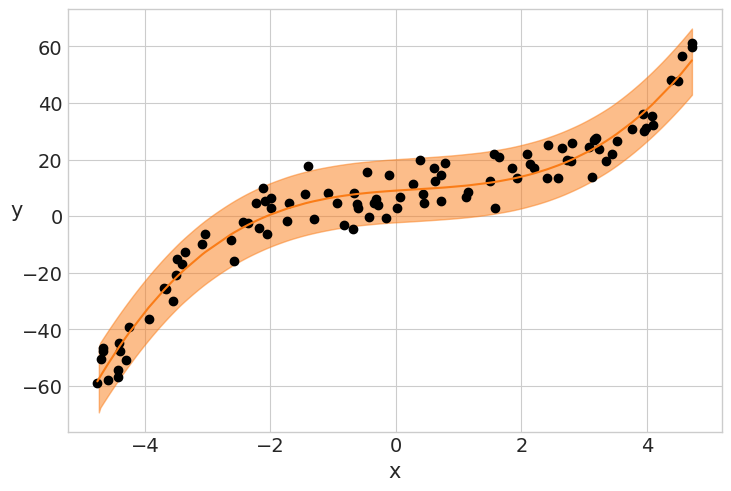

In [40]:
# Plot the predictions HDI interval
plt.plot(x, y, 'o', color='k')
az.plot_hdi(x, ppc['y_pred'])
idx = np.argsort(x)
plt.plot(x[idx], alpha_m + np.dot(basis_x[idx], beta_m[:, np.newaxis]), c='C1')
plt.xlabel('x'); plt.ylabel('y', rotation=0)
plt.show()

## Multivariate Polynomial Regression

Dealing with multivariate data, in the classical formulation of linear regression we have assumed that the effect of each feature on the target feature is independent with respect to the other features. However, this is not always the case, e.g. different drugs interactions and positive or negative effects on a patient. Modeling this kind of phenomena requires the introduction of **interaction effects**.

For example, given two features $X_1$ and $X_2$, a linear model incorporating interaction effects between them can be described as follows:

$$\mu = \alpha + \beta_1X_1+\beta_2X_2+\beta_3X_1X_2$$

$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

where $\beta_3$ is the coefficient for the interaction term $X_1X_2$. Just like classical linear regression, we can impose prior distributions on the parameters of our model.

Interaction effects are the main components of a **multi-variate polynomial regression** model.
Fore example, given three features $X_1,X_2,X_3$, a quadratic multi-variate regression model can be described as follows.

$$\mu = \alpha + \beta_1X_1 + \beta_2X_2 + \beta_3X_3 + \beta_4X_1X_2 + \beta_5X_2X_3 + \beta_6X_1X_3 + \beta_7X_1^2 + \beta_8X_2^2 + \beta_9X_3^2$$

$$Y \sim \mathrm{Normal}(\mu, \epsilon)$$

Given $d$ the number of features and $N$ the grade of the polynomial, the number of terms appearing in $\mu$ is the number of _combinations with replacement_ of $d+1$ objects in groups of $N$, and we can write:

$$\binom{(d + 1) + N - 1}{N} = \binom{d+N}{N} = \mathcal{O}(d^N)$$

However, we can decide to discard some un-promising interactions between features to tackle down the computational complexity, e.g. considering only interactions between features without powers.

# Splines

## Splines

Until now, we built our regression model as a single (multivariate) polynomial model (e.g. linear regression or polynomial regression).
However, we can consider different polynomials in different regions of the features space.
For example, we can use a piecewise cubic function defined as follows.

$$\mu = \begin{cases}
\alpha_1 + \beta_{11}X + \beta_{12}X^2 + \beta_{13}X^3 & \text{if}\ X < \xi \\
\alpha_2 + \beta_{21}X + \beta_{22}X^2 + \beta_{23}X^3 & \text{if}\ X \geq \xi 
\end{cases}$$

$$Y \sim \mathcal{N}(\mu,\epsilon)$$

where $\xi$ is a **knot** in the features space.

We can have an arbitrarily number of knots $\xi_1,\xi_2,\ldots,\xi_K$ and $K+1$ different local functions, such that $\xi_i < \xi_j$ if and only if $i<j$.
However, we do _not_ want _discontinuities_ in our overall function.
**Splines** are piecewice functions that satisfy continuity, and in some cases even _differentiability_.

### Linear Splines

A **linear spline** with knots $\xi_1,\xi_2,\ldots,\xi_K$ is a piecewise linear function which is continuous at each knot.
From a Bayesian point of view, a linear spline can be written as follows in terms of linear combination of basis functions.

$$\mu=\alpha + \sum_{i=1}^{K+1}\beta_iB_i(X) \qquad Y\sim\mathcal{N}(\mu,\epsilon)$$

$$B_1(X) = X \qquad B_{k+1}(X) = (X-\xi_k)_+ \qquad 1\leq k\leq K$$

where $(X-\xi)_+$ denotes $\max(0,X-\xi)$.

The choice of knots $\xi_1,\xi_2,\ldots,\xi_K$ is not trivial and depends on the data.
A straightforward way to set such points is to cover the features space _uniformly_.
Another way is to set them by using _quantiles_ of the input features distribution.

We can also have multi-variate and polynomial splines too !

### Example

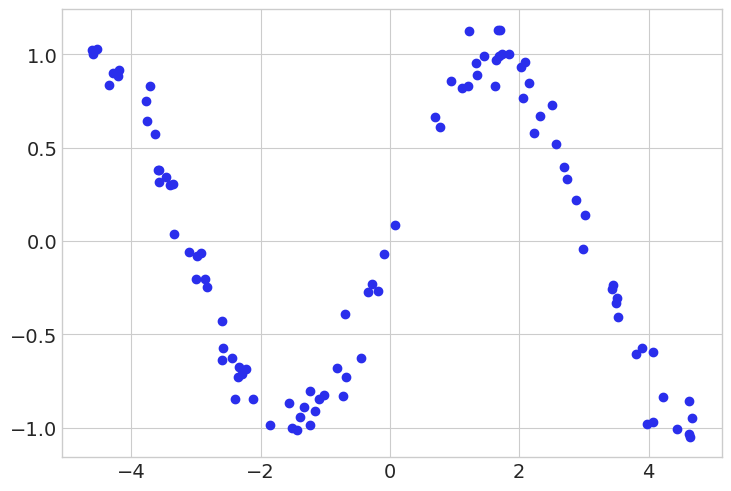

In [51]:
# Setup a noisy sine wave function
def nl(x): return np.sin(x)
x = 1.5 * np.pi * (2.0 * np.random.rand(100) - 1.0)
y = nl(x) + 0.1 * np.random.randn(len(x))
plt.plot(x, y, 'o')
plt.show()

In [52]:
# Initialize the knots uniformly
n_knots = 2
dx = np.max(x) - np.min(x)
knots = [np.min(x) + dx * (k + 1) / (n_knots + 1) for k in range(n_knots)]

# Apply the linear spline basis functions
basis_x = np.stack([x] + [np.maximum(0.0, x - k) for k in knots], axis=1)

In [53]:
# Build a PyMC3 linear model
with pm.Model() as model:
    # Intercept and slope priors
    alpha = pm.Normal('alpha', mu=0.0, sd=3.0)
    beta = pm.Normal('beta', mu=0.0, sd=3.0, shape=basis_x.shape[1])
    eps = pm.HalfCauchy('eps', 1.0)

    # Likelihood
    mu = pm.Deterministic('mu', alpha + tt.dot(basis_x, beta))
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)

# Sample from the posterior
with model:
    trace = pm.sample(
        draws=40_000, tune=40_000, target_accept=0.9,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, beta, alpha]


Sampling 2 chains for 40_000 tune and 40_000 draw iterations (80_000 + 80_000 draws total) took 205 seconds.


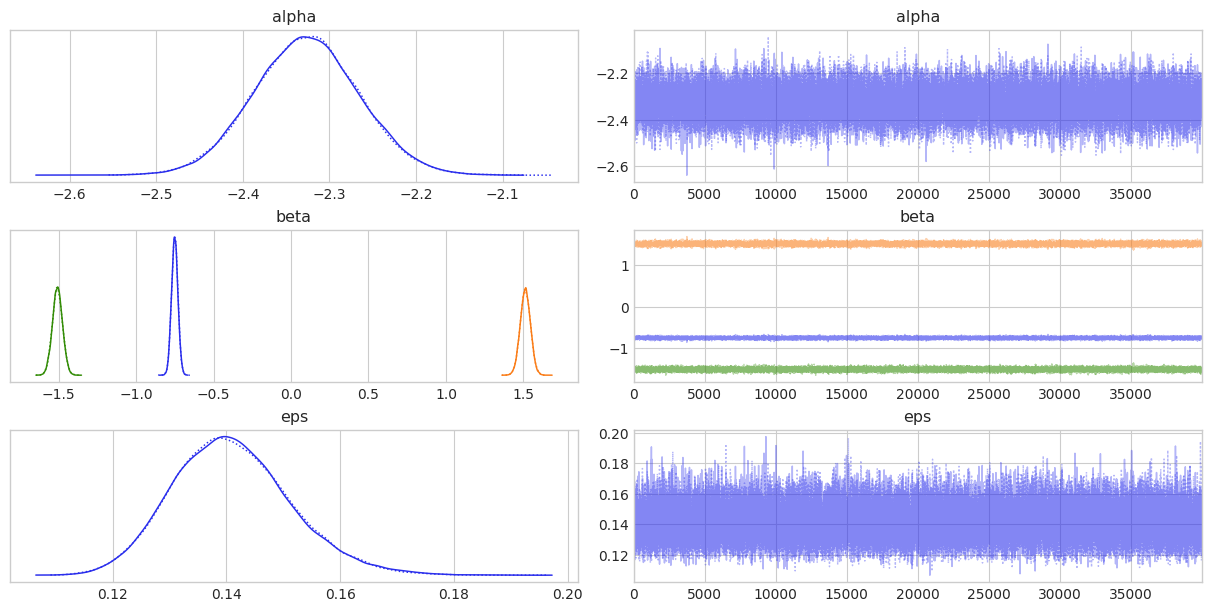

In [54]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps'])
plt.show()

[]

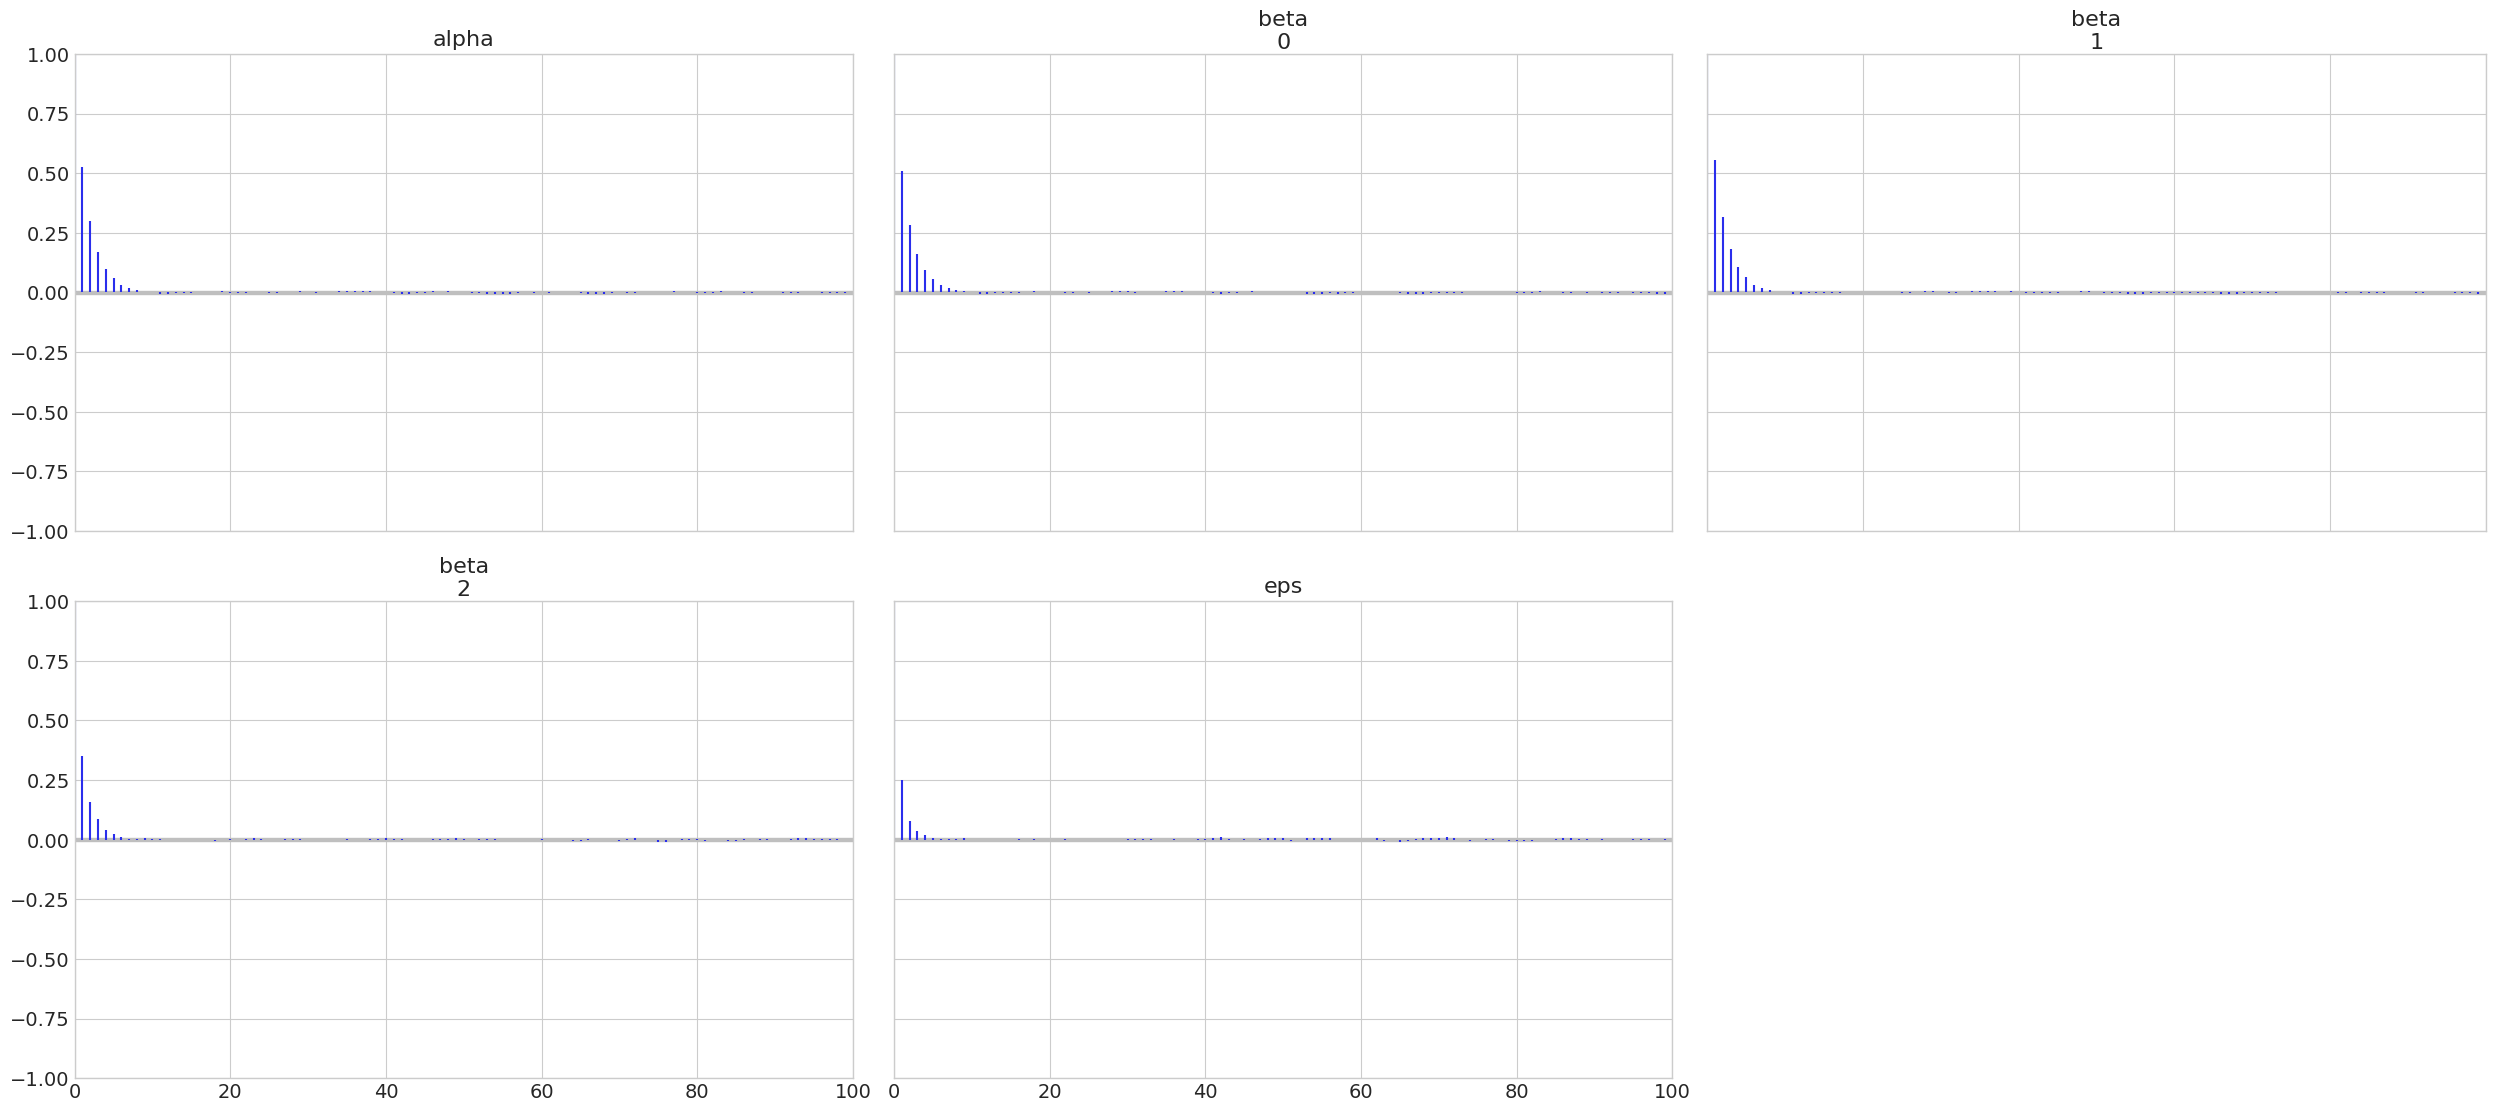

In [55]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'eps'], combined=True)
plt.plot()

In [56]:
# Compute average values of sampled parameters
alpha_m = np.asarray(trace['posterior']['alpha']).mean()
beta_m = np.asarray(trace['posterior']['beta']).reshape(-1, basis_x.shape[1]).mean(axis=0)

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

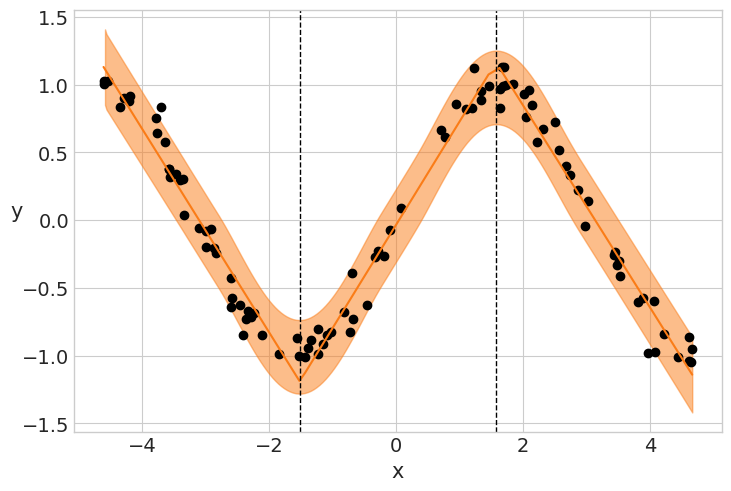

In [57]:
# Plot the predictions HDI interval
plt.plot(x, y, 'o', color='k')
az.plot_hdi(x, ppc['y_pred'])
idx = np.argsort(x)
plt.plot(x[idx], alpha_m + np.dot(basis_x[idx], beta_m[:, np.newaxis]), c='C1')
plt.xlabel('x'); plt.ylabel('y', rotation=0)
for k in knots: plt.axvline(k, c='k', linestyle='--', lw=1)
plt.show()

## Linear Spline with Knots Prior

It is also possible to define a prior over knots, at the cost of a way higher computational complexity when sampling from the posterior.
That is, we can define a prior over $K$ knots in the range $(0, 1)$ in order to ensure that $\xi_i < \xi_j$ if and only if $i<j$.
To do so, we first impose a Dirichlet prior distribution on additional variables $\tau_1,\tau_2,\ldots,\tau_{K+1}$ as follows.

$$\tau \sim \mathrm{Dirichlet}(\alpha_1,\alpha_2,\ldots,\alpha_{K+1}) \qquad \alpha_i > 0 \quad 1\leq i\leq K+1$$

The Dirichlet distribution has two important properties.

$$\tau_i \in (0,1) \quad 1\leq i\leq K+1 \qquad \sum_{i=1}^{K+1}\tau_i=1$$

$$\mathbb{E}[\tau_i] = \frac{\alpha_i}{\sum_{i=1}^{K+1}\alpha_i}$$

We can then define a prior distribution on knots as follows.

$$\xi_0=0 \qquad \xi_i \sim \xi_{i-1} + \tau_i \qquad 1\leq i\leq K$$

Now consider the case of $\alpha_i=1\quad 1\leq i\leq K+1$.
The choice of this prior on knots $\xi_1,\xi_2,\ldots,\xi_K$ is interesting because the _expected knots_ are distributed _uniformly_ in the interval $(0, 1)$.

$$\xi_i\in (0,1) \qquad \mathbb{E}[\xi_i] = i\frac{1}{K+1} \qquad 1\leq i\leq K$$

### Example

In [58]:
# Initialize the number of knots
n_knots = 2

# Build a PyMC3 linear spline model
with pm.Model() as model:
    # Prior distributions
    alpha = pm.Normal('alpha', mu=0.0, sd=3.0)
    beta = pm.Normal('beta', mu=0.0, sd=3.0, shape=n_knots + 1)
    eps = pm.HalfCauchy('eps', 1.0)

    # Knots distribution
    tau = pm.Dirichlet('tau', [1.0] * (n_knots + 1))
    xi = pm.Deterministic('xi', x.min() + (x.max() - x.min()) * tt.cumsum(tau[:-1]))

    # Likelihood
    unsq_x = x[:, np.newaxis]
    basis_x = tt.concatenate([unsq_x, tt.nnet.relu(unsq_x - xi)], axis=1)
    mu = pm.Deterministic('mu', alpha + tt.dot(basis_x, beta))
    y_pred = pm.Normal('y_pred', mu=mu, sd=eps, observed=y)
    
# Sample from the posterior
with model:
    trace = pm.sample(
        draws=40_000, tune=40_000, target_accept=0.9,
        chains=2, cores=2, random_seed=42,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [tau, eps, beta, alpha]


Sampling 2 chains for 40_000 tune and 40_000 draw iterations (80_000 + 80_000 draws total) took 599 seconds.


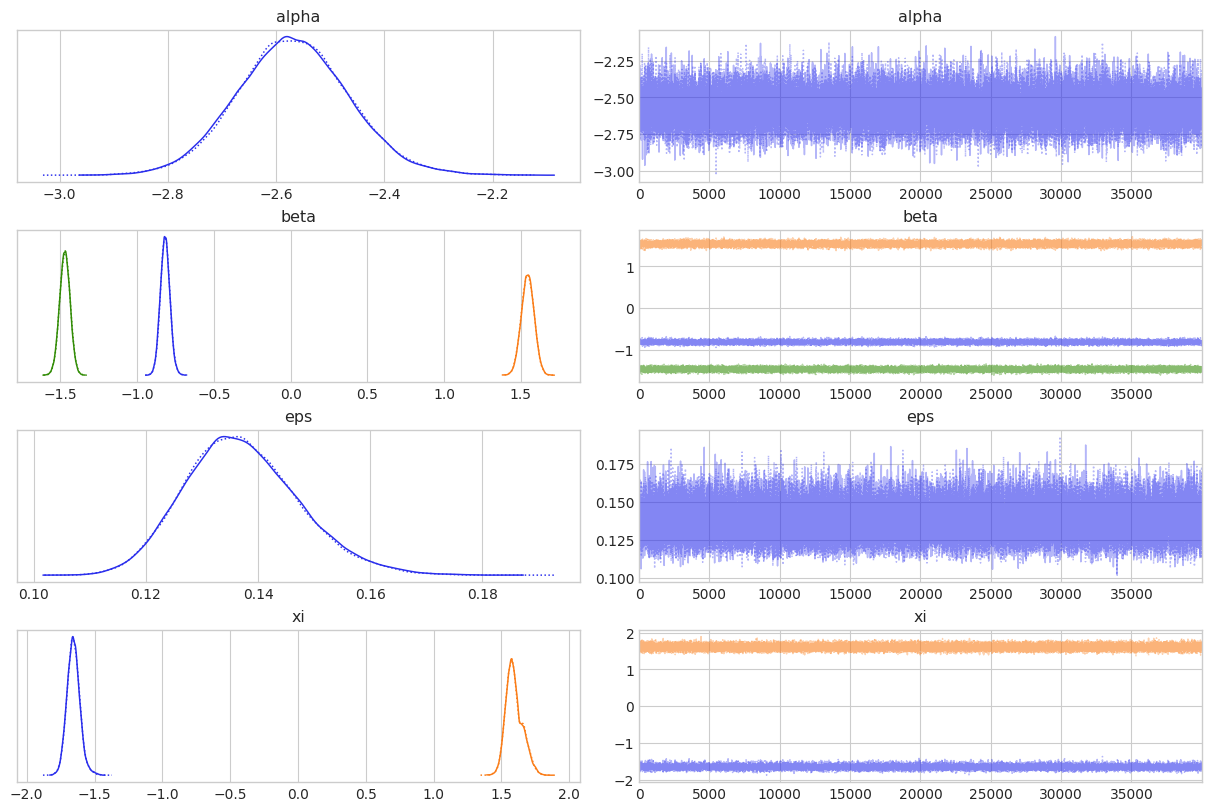

In [63]:
# Plot the trace
az.plot_trace(trace, var_names=['alpha', 'beta', 'eps', 'xi'])
plt.show()

[]

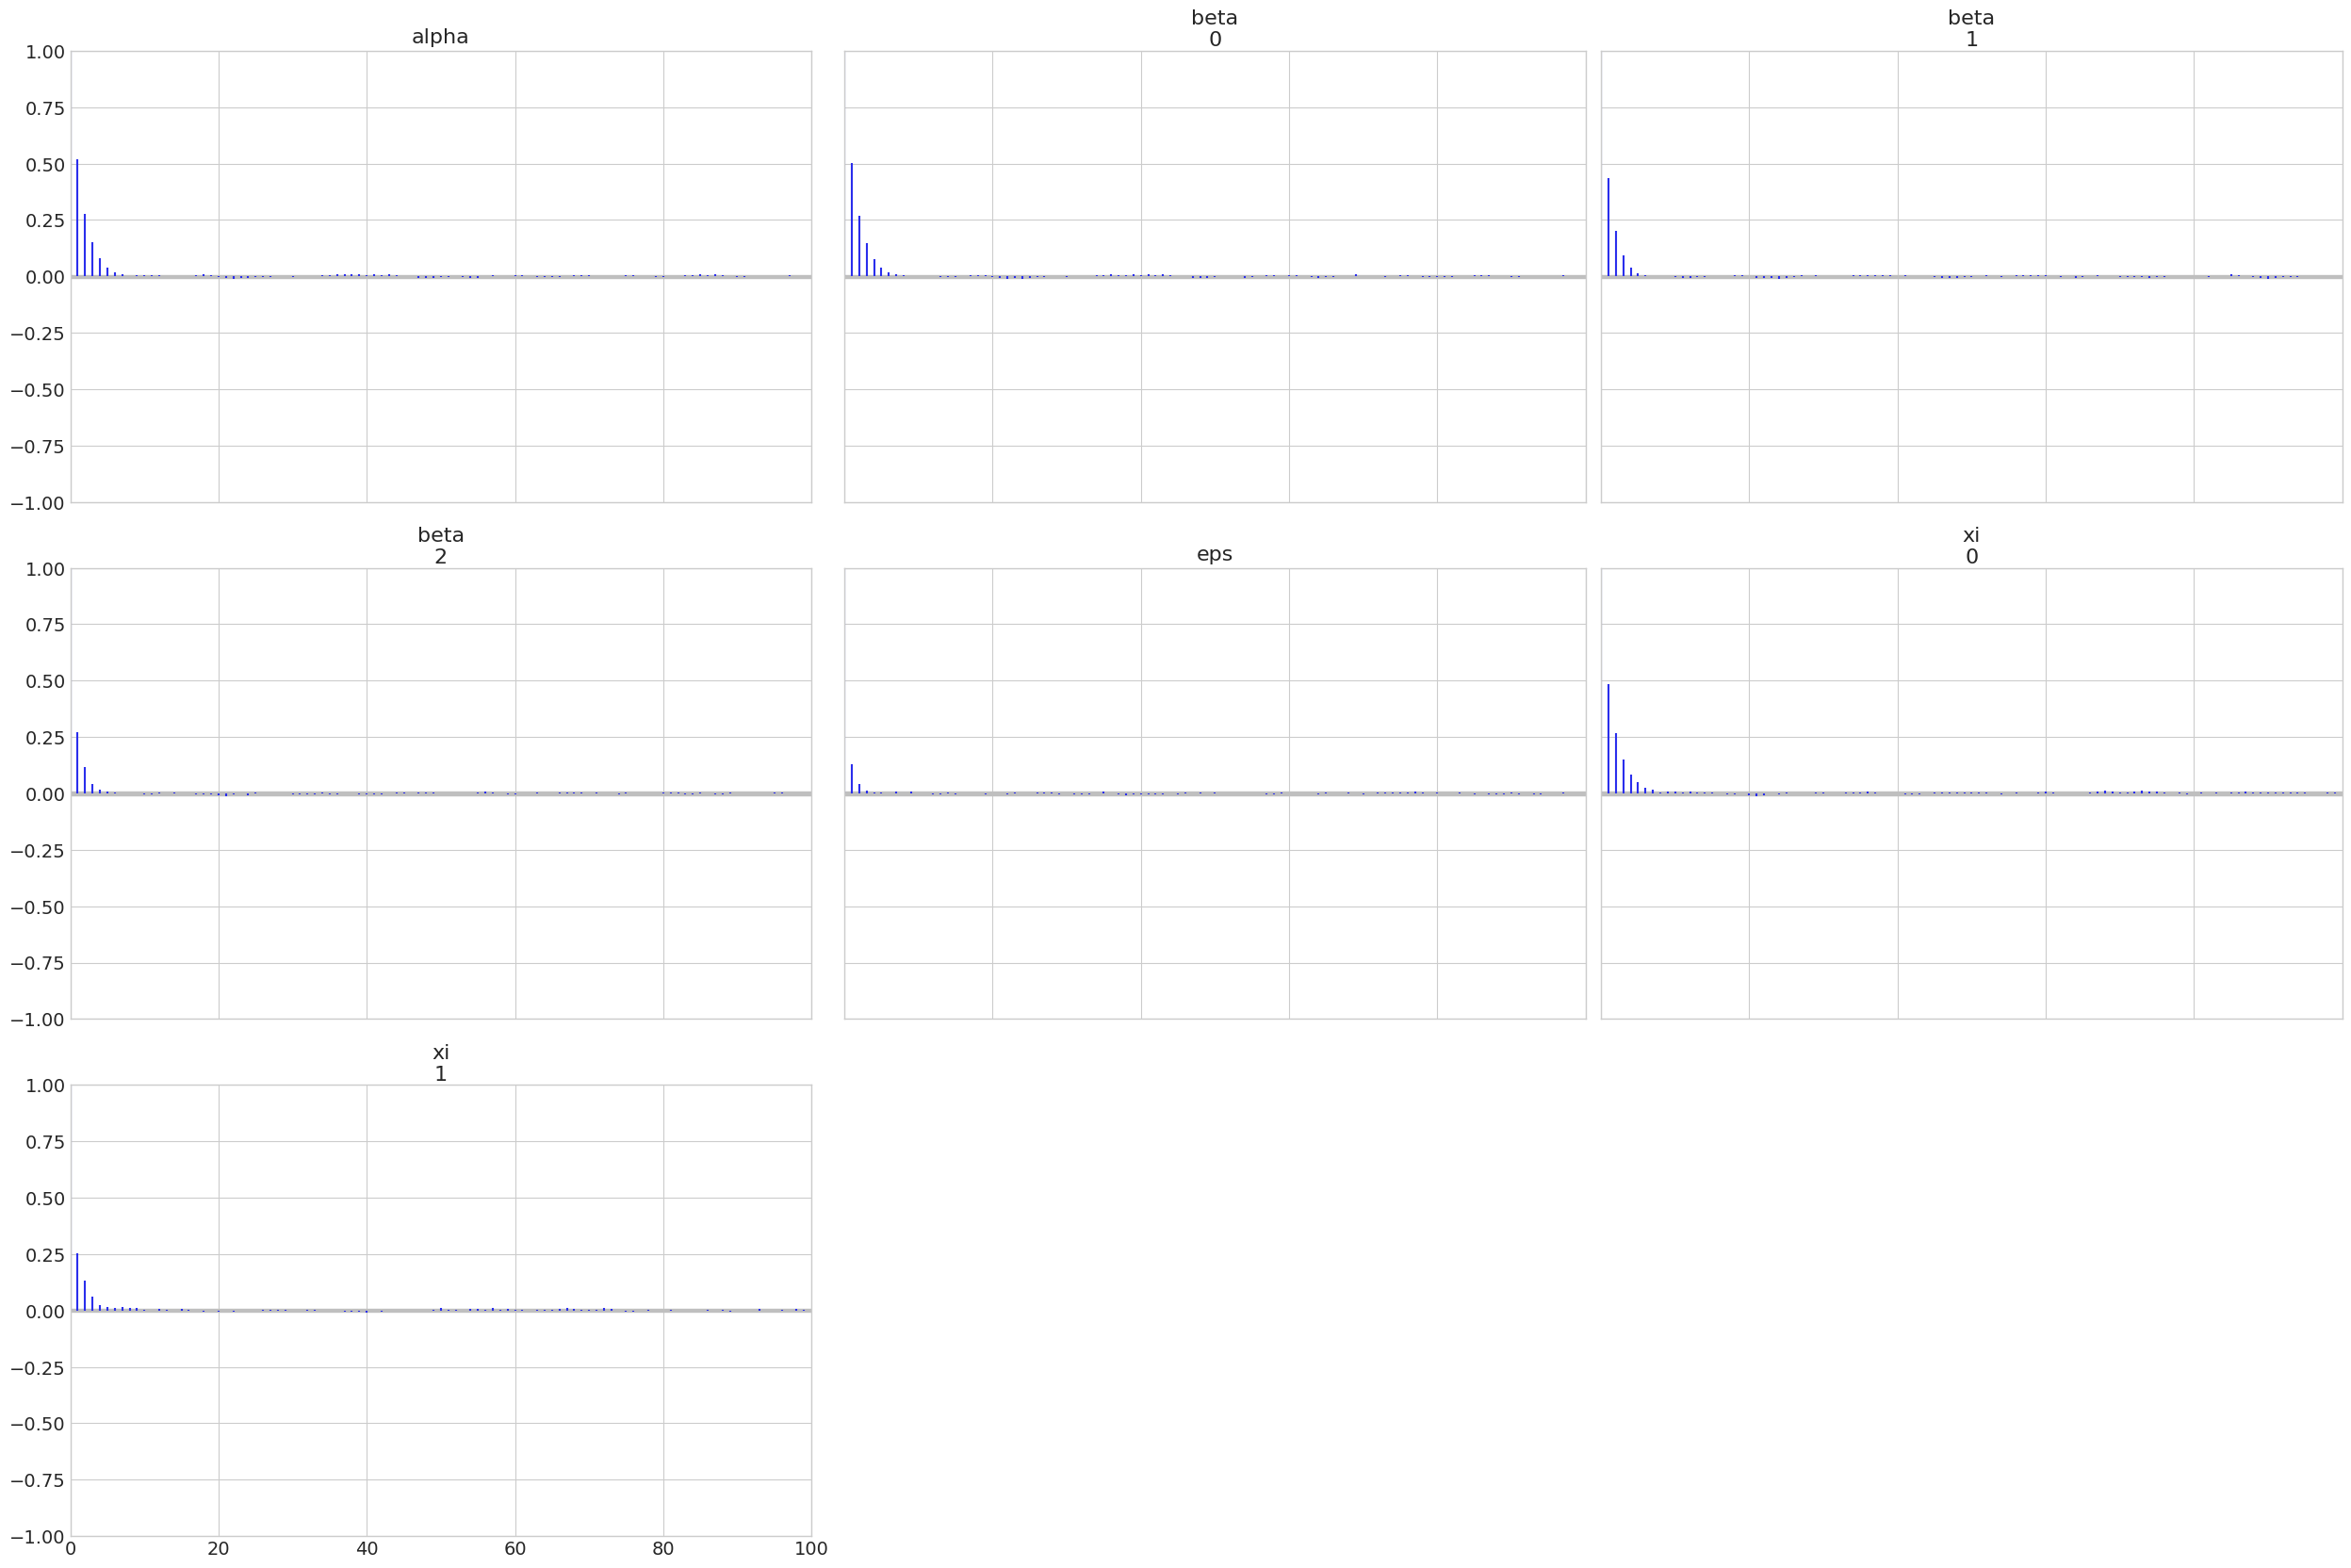

In [64]:
# Plot auto-correlation plots
az.plot_autocorr(trace, var_names=['alpha', 'beta', 'eps', 'xi'], combined=True)
plt.plot()

In [59]:
# Compute average values of sampled parameters
alpha_m = np.asarray(trace['posterior']['alpha']).mean()
beta_m = np.asarray(trace['posterior']['beta']).reshape(-1, n_knots + 1).mean(axis=0)
xi_m = np.asarray(trace['posterior']['xi']).reshape(-1, n_knots).mean(axis=0)

# Sample the predictions
with model:
    ppc = pm.fast_sample_posterior_predictive(trace, keep_size=True)

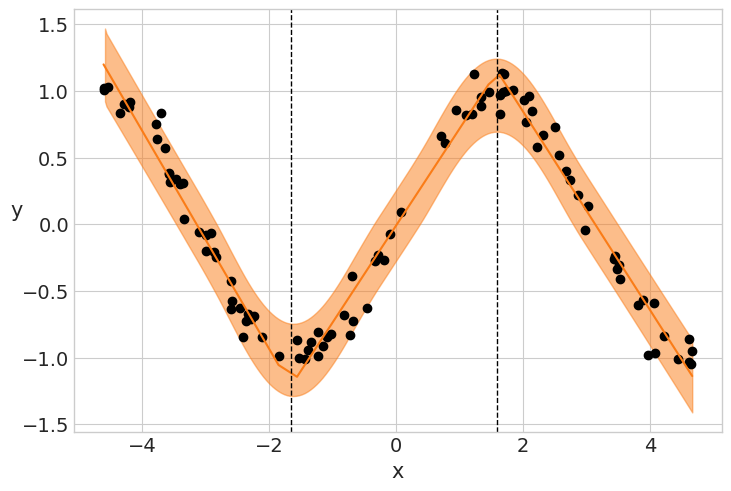

In [60]:
# Plot the predictions HDI interval
plt.plot(x, y, 'o', color='k')
az.plot_hdi(x, ppc['y_pred'])
basis_x = np.concatenate([x[:, np.newaxis], np.maximum(0.0, x[:, np.newaxis] - xi_m)], axis=1)
idx = np.argsort(x)
plt.plot(x[idx], alpha_m + np.dot(basis_x[idx], beta_m[:, np.newaxis]), c='C1')
plt.xlabel('x'); plt.ylabel('y', rotation=0)
for k in xi_m: plt.axvline(k, c='k', linestyle='--', lw=1)
plt.show()